# Adversarial Attacks on ConvNets

Ref: https://github.com/gongzhitaao/tensorflow-adversarial

In [3]:
%%javascript
IPython.notebook.clear_all_output();




<IPython.core.display.Javascript object>

## Step 1: Data Preparation

In [4]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

img_size = 28 # images to DL models are of size 28 x 28
img_chan = 1 # the channel dimension, = 1 since the MNIST dataset is grayscale
n_classes = 10 # classes are the 10 digits


Load the MNIST dataset, the "hello world" dataset for deep learning

|X_train|: (60000, 28, 28)
|y_train|: (60000,)
|X_test|: (10000, 28, 28)
|y_test|: (10000,)


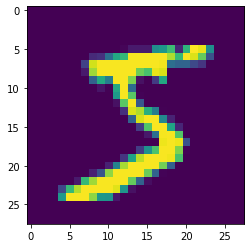

In [5]:


mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('|X_train|:', X_train.shape)
print('|y_train|:', y_train.shape)
print('|X_test|:', X_test.shape)
print('|y_test|:', y_test.shape)



#Show the 1st training image with matplotlib
plt.imshow(X_train[0])
plt.show()


Add the channel dimension to be TensorFlow-compatible; normalize pixel to be within [0, 1]

In [6]:
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

print('|X_train|:', X_train.shape)
print('|X_test|:', X_test.shape)

|X_train|: (60000, 28, 28, 1)
|X_test|: (10000, 28, 28, 1)



One-hot encoding the labels to be TensorFlow-compatible:

In [7]:


to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print('|y_train|:', y_train.shape)
print('|y_test|:', y_test.shape)

|y_train|: (60000, 10)
|y_test|: (10000, 10)


In [8]:

print(y_test[0]) # see the one-hot encoding of the label of the 1st test data

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Shuffle the training dataset:

In [9]:
num_train = X_train.shape[0]

ind = np.random.permutation(num_train)
X_train, y_train = X_train[ind], y_train[ind]

Splitting the training dataset into `training` and `validation` datasets

In [10]:
VALIDATION_SPLIT = 0.1 # hold out 10% training data for validation
n = int(num_train * (1-VALIDATION_SPLIT)) # splitting index

# take validation data objects first, as training data will change later
X_valid = X_train[n:]
y_valid = y_train[n:]

X_train = X_train[:n]
y_train = y_train[:n]

print('|X_train|:', X_train.shape)
print('|y_train|:', y_train.shape)
print('|X_valid|:', X_valid.shape)
print('|y_valid|:', y_valid.shape)

|X_train|: (54000, 28, 28, 1)
|y_train|: (54000, 10)
|X_valid|: (6000, 28, 28, 1)
|y_valid|: (6000, 10)


## Step 2: Construct Compuational Graph


`tf.variable_scope` defines a prefix for the operations and variables defined within the scope.

You have to use `tf.variable_scope` if you want to create a variable with the same name of another variable but in a different scope.

We will use functions in `tf.layers` such as `conv2d`, `max_pooling2d`, `dense` and `dropout` to define our model, see https://www.tensorflow.org/api_docs/python/tf/layers for a full list.

We will use functions in `tf.nn` such as `softmax` to define our model, see https://www.tensorflow.org/api_docs/python/tf/nn for a full list.

In [11]:
def model(x, logits=False, training=False):
# logits: whether to return logits
    with tf.variable_scope('conv0'):
        z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)
        
        

    with tf.variable_scope('conv1'):
        z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('flatten'):
        shape = z.get_shape().as_list()
        # tf.Tensor.get_shape() is a member function of TensorFlow Tensor.
        # The shape information inferred by it may be incomplete.
        # Recommended Readings:
        # http://www.heyuhang.com/blog/2018/07/14/tensorflow-get-shape-vs-tf-dot-shape/
        z = tf.reshape(z, [-1, np.prod(shape[1:])])

    with tf.variable_scope('mlp'):
        z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
        # dropout has two mode: training and testing
        z = tf.layers.dropout(z, rate=0.25, training=training)

    logits_ = tf.layers.dense(z, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')

    if logits: return y, logits_
    else: return y



**This is the input (i.e., function object) to our attacking functions later !!!**


Question: Please list the layers in the model.

**[Your Answer Here]**

conv0 layer, conv1 layer, dense layer, logits layer


Create an environment variable to carry variables in its fields.

For this, we need to create a dummy class as the type of the environment variable.

In [12]:
class Environment:
    pass # a class with no methods (yet)

env = Environment() # this is the GLOBAL environment variable



Define model data-inputs (images, labels), which will be provided using argument `feed_dict` to `session.run(.)`.

Define model outputs (accuracy, loss, optimizer), which will be returned by `session.run(.)`.

In [13]:


with tf.variable_scope('model'):
    # INPUTS to the model
    env.x = tf.placeholder(tf.float32, (None, img_size, img_size, img_chan), name='x')
    # 'None' means the number of training data will be determined when session.run(.) is called
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder_with_default(False, (), name='mode')
    # 'False' is the default value used if the value of env.training is not provided to session.run(.)
    # '()' means the placeholder is a constant (0-dimensional)
    # note that 1-dimensional object is an array

    # call our defined model to get its outputs
    env.ybar, logits = model(env.x, logits=True, training=env.training)

    # OUTPUT 1: accuracy to be returned by session.run(.)
    with tf.variable_scope('acc'):
        # Check https://www.tensorflow.org/api_docs/python/tf/math/argmax
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        # Check https://www.tensorflow.org/api_docs/python/tf/dtypes/cast
        # and https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')
    
    # OUTPUT 2: loss to be returned by session.run(.)
    with tf.variable_scope('loss'):
        # cross_entropy_loss over softmax_logits
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=logits)
        # average over all data samples
        env.loss = tf.reduce_mean(xent, name='loss')
    
    # Define optimizer over loss
    with tf.variable_scope('train_op'):
        optimizer = tf.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

    # dependency for training:
    # train_op ----<backprop>---- loss ----<fwd_model>---- inputs
    
    # dependency for testing:
    # inputs ----<fwd_model>----> loss

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



**Think:** Refer back to course slides and try to comprehend what `optimizer.minimize(.)` here does and returns; for example, it handles `tf.gradient(.)` and weight parameter update by `tf.reassign(.)`.


Define model job-configuration-inputs (eps, epochs, targeted_label), which will be provided using argument `feed_dict` to `session.run(.)`.

In [14]:
with tf.variable_scope('model', reuse=True): # reuse the above defined var-scope
    # adv means adversarial
    env.adv_eps = tf.placeholder(tf.float32, (), name='adv_eps')
    env.adv_epochs = tf.placeholder(tf.int32, (), name='adv_epochs')
    env.adv_y = tf.placeholder(tf.int32, (), name='adv_y')

## Step 3: Training Our DL Model

Initialize computational graph:

Note: this must be done after computational graph is constructed, so that all variables are properly initialized.

In [15]:
# An InteractiveSession installs itself as the default session on construction,
# It avoids having to pass an explicit Session object to run op
sess = tf.InteractiveSession()

# Initialize model parameters (TensorFlow Variables)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

Write a function to evaluate a model. Evaluate the model by running `env.loss` and `env.acc` (only forward propagation).

Used by our training process to report current loss.

In [16]:


def evaluate(X_data, y_data, batch_size=128):
    
    n_sample = X_data.shape[0]
    n_batch = (n_sample+batch_size-1) // batch_size # number of mini-batches
    
    loss, acc = 0, 0

    for batch in range(n_batch):
        print('[Evaluation] batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        cnt = end - start # weight for the current mini-batch
        batch_loss, batch_acc = sess.run(
            [env.loss, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end]})
        loss += batch_loss * cnt
        acc += batch_acc * cnt
    loss /= n_sample
    acc /= n_sample

    print('* loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

Training parameters:

In [17]:


batch_size = 128 # size of mini-batch
epochs = 5
name = 'mnist' # model name

In [18]:
num_train = X_train.shape[0]
n_batch = (num_train + batch_size - 1) // batch_size # number of mini-batches per epoch / data-pass
print('n_batch:', n_batch)

n_batch: 422



Train the model by running `env.train_op` returned by optimizer (need backpropagation).

In [19]:
for epoch in range(epochs):
    print('Epoch {0}/{1}'.format(epoch + 1, epochs))

    # shuffle data (once per epoch)
    ind = np.arange(num_train)
    np.random.shuffle(ind)
    X_train = X_train[ind]
    y_train = y_train[ind]

    for batch in range(n_batch):
        print('[Training] Batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        ######################################################################
        # TODO: your code here ...                                           #
        ######################################################################
        start = batch * batch_size
        end = min(num_train, start + batch_size)
        cnt = end - start # weight for the current mini-batch
        sess.run(env.train_op, feed_dict={env.x: X_train[start:end],env.y: y_train[start:end],env.training: True})
        ######################################################################
        #                          END OF YOUR CODE                          #
        ######################################################################
    
    # evaluate on validation dataset (once per epoch)
    evaluate(X_valid, y_valid)

Epoch 1/5
* loss: 0.0818 acc: 0.9748
Epoch 2/5
* loss: 0.0643 acc: 0.9815
Epoch 3/5
* loss: 0.0463 acc: 0.9865
Epoch 4/5
* loss: 0.0459 acc: 0.9878
Epoch 5/5
* loss: 0.0489 acc: 0.9867





Evaluate on test dataset:

In [20]:
evaluate(X_test, y_test)

* loss: 0.0272 acc: 0.9907


(0.027202598372800275, 0.9907)

## Step 4: The Prediction Function

First define the predict function that takes X and return score vector y (per sample):

Needed to compute the label, used to check the prediction of test images and their adversarial versions.

In [21]:
def predict(X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    n_classes = env.ybar.get_shape().as_list()[1]

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    yval = np.empty((n_sample, n_classes))

    for batch in range(n_batch):
        print('[Prediction] batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        ######################################################################
        # TODO: your code here ...                                           #
        ######################################################################
        
        y_batch = sess.run(env.ybar, feed_dict={env.x: X_data[start:end]})
        yval[start:end] = y_batch
        
        ######################################################################
        #                              END OF YOUR CODE                      #
        ######################################################################
    print()
    return yval

See how to use it, by predicting the first 2 test samples:

In [22]:
result = predict(X_test[0:2])
result

[Prediction] batch 1/1


array([[8.62194968e-11, 2.46135756e-09, 1.19890249e-08, 4.92983219e-08,
        1.21797183e-10, 9.07682429e-10, 2.32654010e-15, 9.99998927e-01,
        3.87936822e-10, 1.03699097e-06],
       [2.11213536e-08, 4.63901983e-09, 1.00000000e+00, 7.58668573e-13,
        2.26828747e-11, 3.80810048e-13, 2.68510085e-08, 1.83393166e-12,
        2.20932184e-09, 7.58072587e-13]])

In [23]:
print(np.argmax(result, axis=1))

[7 2]


In [24]:
print(y_test[0:2])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


Question: is the predict correct? Why?

**[Your Answer Here]**

yes, because the result of print(np.argmax(result, axis=1)) is 7,2 

## Step 5: Generating Adversarial Images Using FGSM

Let us first implement the Fast Gradient Sign Method (FGSM). Look at its definition here: https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7

We have defined some attack functions in package `attack`, now import them and pass `model` as their input.

Track these attack models in `env`.

In [25]:
from attacks import fgm, fgmt, jsma, deepfool

with tf.variable_scope('model', reuse=True): # reuse var-scope of where we defined models
    env.x_fgsm = fgm(model, env.x, # untargeted
                     epochs=env.adv_epochs, eps=env.adv_eps)
    env.x_fgsmt = fgmt(model, env.x, env.adv_y, # targeted
                     epochs=env.adv_epochs, eps=env.adv_eps)
    env.x_deepfool = deepfool(model, env.x, # untargeted
                              epochs=env.adv_epochs, batch=True)
    env.x_jsma = jsma(model, env.x, env.adv_y, # targeted
                      eps=env.adv_eps, epochs=env.adv_epochs)

Instructions for updating:
Use `tf.cast` instead.


Now we write a function to generate adversarial images of images `X` using FGSM:

In [26]:
def make_fgsm(X_data, epochs=1, eps=0.01, batch_size=128):
    print('\nMaking adversarials via FGSM')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        feed_dict = {env.x: X_data[start:end], env.adv_eps: eps,
                     env.adv_epochs: epochs}
        adv = sess.run(env.x_fgsm, feed_dict=feed_dict)
        X_adv[start:end] = adv
    print()

    return X_adv

Compute predictions of `X_test` and their adversarial images: 

In [27]:
y1 = predict(X_test)

X_adv = make_fgsm(X_test, eps=0.02, epochs=12)
y2 = predict(X_adv)

[Prediction] batch 79/79

Making adversarials via FGSM
 batch 79/79
[Prediction] batch 79/79


One-hot encodings -> labels

In [28]:
z0 = np.argmax(y_test, axis=1) # true label over original images
z1 = np.argmax(y1, axis=1) # predicted label over original images
z2 = np.argmax(y2, axis=1) # predicted label over perturbed images

Check labels of the first 10 images:

In [29]:
print(z0[0:10])
print(z1[0:10])
print(z2[0:10])

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]
[9 6 7 6 9 7 8 4 6 4]


How many perturbed images have the correct label?

**[Your Answer Here]**

None of the perturbed images is correct label

Visualizing results of perturbed images:

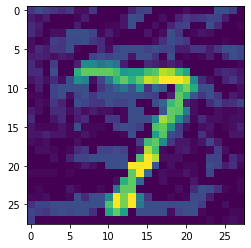

True label: 7
Prediction: 9


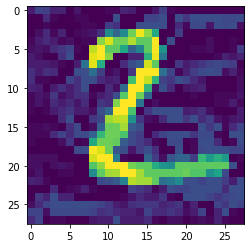

True label: 2
Prediction: 6


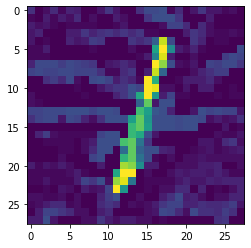

True label: 1
Prediction: 7


In [30]:
for i in range(3): # check 3 results
    plt.imshow(X_adv[i][:, :, 0]) # shape: (28, 28, 1) -> (28, 28)
    # note: you can also use:
    # plt.imshow(np.squeeze(X_adv[i])
    # https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.squeeze.html
    plt.show()
    print('True label:', z0[i])
    print('Prediction:', z2[i])

Now we improve our visualization to be space-efficient and show examples for all classes.

Randomly sample adversarial data from each of the 10 categories:

Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 6
Target 7
Target 8
Target 9

Plotting results


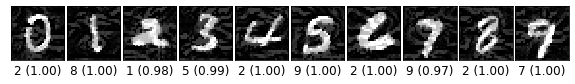

In [31]:
import matplotlib.gridspec as gridspec

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))
for i in range(10):
    print('Target {0}'.format(i))
    ind, = np.where(np.all([z0 == i, z1 == i, z2 != i], axis=0)) # ind = list of positions
    # Function np.all() 'AND's all 3 arrays: an element is True only if all 3 conditions are met
    cur = np.random.choice(ind)
    X_tmp[i] = np.squeeze(X_adv[cur])
    y_tmp[i] = y2[cur]

print('\nPlotting results')

fig = plt.figure(figsize=(10, 1.2))
gs = gridspec.GridSpec(1, 10, wspace=0.05, hspace=0.05)
# Check usage: https://matplotlib.org/users/gridspec.html

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)

How confident are the predictions of the perturbed images?

**[Your Answer Here]**

even evert number is wrong, but almost every number is perfect confident

## Step 6: Understanding FGSM Code

We first explain how to get the shape of a tensor. In TensorFlow, a tensor has both a static (inferred) shape and a dynamic (true) shape.

The static shape can be read using the `tf.Tensor.get_shape()` method: this shape is inferred from the operations that were used to create the tensor, and may be partially complete.

If the static shape is not fully defined, the dynamic shape of a Tensor `t` can be determined by evaluating `tf.shape(t)`.

In [32]:
a = tf.constant([[1, 2, 3], [4, 5, 6]])
print(a)

a_shape = tf.shape(a)
print(a_shape)

Tensor("Const:0", shape=(2, 3), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)


You need to evaluate the shape:

In [33]:

a_shape.eval()

array([2, 3])

Note: since we use `InteractiveSession`, which installs itself as the default session. We can call `tf.Tensor.eval()` function without explicitly calling `sess.run(.)`.

This is equivalent to:

In [34]:
sess.run(a_shape)

array([2, 3])

Instead, you do not need to evaluating if you use `a.get_shape()`:

In [35]:
a.shape

TensorShape([Dimension(2), Dimension(3)])

In [36]:
a.get_shape() # equivalent

TensorShape([Dimension(2), Dimension(3)])

In [37]:
a.get_shape().as_list()

[2, 3]

In [38]:
b = tf.placeholder(tf.float32, shape=(None, 3)) # shape can be incomplete
b.get_shape().as_list()

[None, 3]

If we use `tf.shape(b)`, can the returned incomplete shape be evaluated?

**[Your Answer Here]**

Nope!

Now, let's perturb the first 2 images in `X_test`. Copy them to a new tensor to pertube, called `xadv`.

In [39]:
xadv = tf.identity(X_test[0:2]) # check: https://www.tensorflow.org/api_docs/python/tf/identity
print(xadv) # Tensor
print(xadv.eval()[0].shape) # xadv.eval() returns numpy array

Tensor("Identity:0", shape=(2, 28, 28, 1), dtype=float32)
(28, 28, 1)


**OP 1:** `xadv` ---model---> `ybar`

In [40]:
with tf.variable_scope('model', reuse=True): # this is required
# otherwise, the operations in our model are redefined with the same names
# will report error (you can try); here, so we reuse the model operations
    ybar, logits_ = model(xadv, logits=True)

print(ybar.eval()[0])
yshape = ybar.get_shape().as_list()
ydim = yshape[1]

[8.6219497e-11 2.4613576e-09 1.1989025e-08 4.9298322e-08 1.2179718e-10
 9.0768243e-10 2.3265401e-15 9.9999893e-01 3.8793682e-10 1.0369910e-06]


**OP 2:** `ybar` ---argmax{prob-vec}---> `indices`

Each row of `ybar` is a softmax-probability vector, and we map it to class label:

In [41]:
indices = tf.argmax(ybar, axis=1)
print(indices.eval())

[7 2]


**OP 3:** `indices` ---tf.one_hot---> `target`

Now each label is changed to one-hot encoding. OP1, OP2 and OP3 essentially converts probability vector to one-hot encoding of prediction.

In [42]:
target = tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0)
print(target.eval())

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


Now we compute loss `J` from vectors `target` (original prediction, considered true and to perturb) and `logits` (scores computed by `model(xadv)`).

In [43]:
J = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=logits_)
print(logits_.eval())
print()
print(J.eval())

[[ -5.82823     -2.476657    -0.8933795    0.52051955  -5.482768
   -3.4742315  -16.3485      17.345894    -4.324283     3.5667078 ]
 [ -0.75309217  -2.2688735   16.91989    -10.987321    -7.589521
  -11.676586    -0.5130729  -10.104671    -3.0106912  -10.988108  ]]

[1.1920922e-06 0.0000000e+00]


We are using the notations here: https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7. Now let us complete FGSM:

In [44]:
# Now, our input `xadv = tf.identity(X_test[0:2])` is a constant
# gradient will be evaluated to be zero (= None)

# recall that we have defined model input env.x, can be reused

# loss needs to be redefined, compared not with true label, 
# but the predicted label (which is to be changed)
yshape = env.ybar.get_shape().as_list()
ydim = yshape[1]
indices = tf.argmax(env.ybar, axis=1)
target = tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0)
J = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=logits)
#J = tf.nn.softmax_cross_entropy_with_logits(labels=y_test[:10], logits=logits) ### hint ###

# Now we implement FGSM using notations of:
# https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7
eps=0.02

# Check: https://www.tensorflow.org/api_docs/python/tf/gradients
dJ_dxadv = tf.gradients(J, env.x)[0] # tf.gradients returns a singleton list

# Check: https://www.tensorflow.org/api_docs/python/tf/stop_gradient
xadv = tf.stop_gradient(env.x + eps*tf.sign(dJ_dxadv)) #outputs its input tensor as-is
# note: the new 'xadv' is treated as a constant, not backpropagation during eval
# thus, it will not propagation -> J -> model, and trained model parameters are protected

# Check: https://www.tensorflow.org/api_docs/python/tf/clip_by_value
xadv = tf.clip_by_value(xadv, 0.0, 1.0) # we assume pixel values are within [0, 1]

feed_dict = {env.x: X_test[0:10]} # input is test images
X_adv = sess.run(xadv, feed_dict=feed_dict)

This is one iteration, see how it performs:

[Prediction] batch 1/1
[Prediction] batch 1/1
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


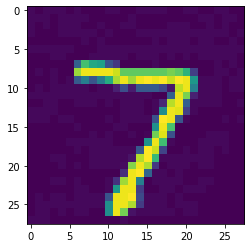

True label: 7
Prediction: 7


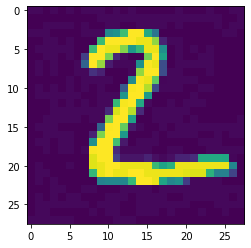

True label: 2
Prediction: 2


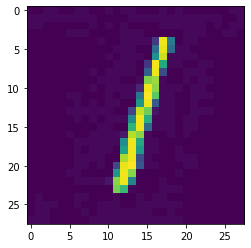

True label: 1
Prediction: 1


In [45]:
y1 = predict(X_test[0:10])
y2 = predict(X_adv)

z1 = np.argmax(y1, axis=1) # predicted label over original images
z2 = np.argmax(y2, axis=1) # predicted label over perturbed images
print(z1)
print(z2)

for i in range(3): # check 3 results
    plt.imshow(X_adv[i][:, :, 0]) # shape: (28, 28, 1) -> (28, 28)
    # note: you can also use:
    # plt.imshow(np.squeeze(X_adv[i])
    # https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.squeeze.html
    plt.show()
    print('True label:', z0[i])
    print('Prediction:', z2[i])

Not effective at all!

How about running for 11 more iterations?

In [46]:
for _ in range(11):
    feed_dict = {env.x: X_adv} # input is previously perturbed images
    X_adv = sess.run(xadv, feed_dict=feed_dict)

[Prediction] batch 1/1
[Prediction] batch 1/1
[7 2 1 0 4 1 4 9 5 9]
[7 2 4 6 4 7 8 4 5 8]


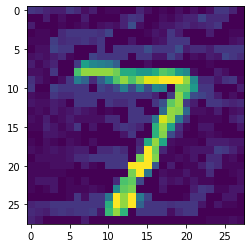

True label: 7
Prediction: 7


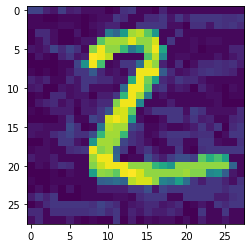

True label: 2
Prediction: 2


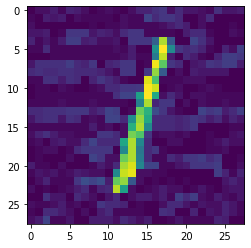

True label: 1
Prediction: 4


In [47]:
y1 = predict(X_test[0:10])
y2 = predict(X_adv)

z1 = np.argmax(y1, axis=1) # predicted label over original images
z2 = np.argmax(y2, axis=1) # predicted label over perturbed images
print(z1)
print(z2)

for i in range(3): # check 3 results
    plt.imshow(X_adv[i][:, :, 0]) # shape: (28, 28, 1) -> (28, 28)
    # note: you can also use:
    # plt.imshow(np.squeeze(X_adv[i])
    # https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.squeeze.html
    plt.show()
    print('True label:', z0[i])
    print('Prediction:', z2[i])

Still not as effective as `make_fgsm(.)`. Why? And how to fix it?

**[Your Answer Here]** Hint: search for ### hint ### in this notebook

because it needs more train

Now, refer back to `make_fgsm(.)`, in it `sess.run(.)` is called on `env.x_fgsm`, which is set using function `fgm(.)` in `attack/fast_gradient.py`. Please open that file and read the function. You may find the following links helpful:
1. https://docs.w3cub.com/tensorflow~python/tf/while_loop/
2. https://www.tensorflow.org/api_docs/python/tf/cond

What is the difference there compared with the one implemented in this notebook?

**[Your Answer Here]**

because if the tensorflow, we are using tensorflow, but they are not 

## Step 7: Understanding T-FGSM

Read function `fgmt(.)` in `attack/fast_gradient.py`. Note that there is one more input `y` (target label) which is set as the least likely class by default.

Write `make_fgsmt` following how `make_fgsm` is wrote:

In [48]:
def make_fgsmt(X_data, y_adv, epochs=1, eps=0.01, batch_size=128):
    ######################################################################
    # TODO: your code here ...                                           #
    ######################################################################
    print('\nMaking adversarials via JSMA')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        feed_dict = {
            env.x: X_data[start:end],
            env.adv_y: np.random.choice(n_classes),
            env.adv_epochs: epochs,
            env.adv_eps: eps}
        adv = sess.run(env.x_jsma, feed_dict=feed_dict)
        X_adv[start:end] = adv
    print()

    return X_adv
    ######################################################################
    #                              END OF YOUR CODE                      #
    ######################################################################

Now, try it on `X_test[0:3]`:

In [49]:
X_adv = make_fgsmt(X_test[0:3], 1, eps=0.02, epochs=12)


Making adversarials via JSMA
 batch 1/1


[Prediction] batch 1/1
[Prediction] batch 1/1
[7 2 1]
[7 2 1]


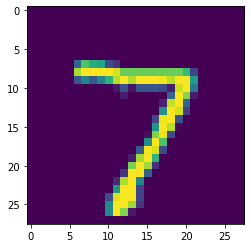

True label: 7
Prediction: 7


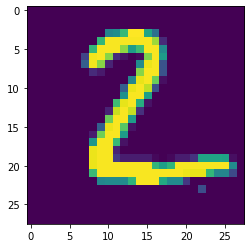

True label: 2
Prediction: 2


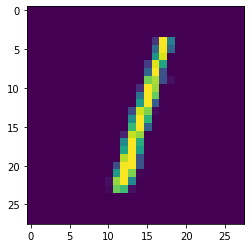

True label: 1
Prediction: 1


In [50]:
y1 = predict(X_test[0:3])
y2 = predict(X_adv)

z1 = np.argmax(y1, axis=1) # predicted label over original images
z2 = np.argmax(y2, axis=1) # predicted label over perturbed images
print(z1)
print(z2)

for i in range(3): # check 3 results
    plt.imshow(X_adv[i][:, :, 0]) # shape: (28, 28, 1) -> (28, 28)
    # note: you can also use:
    # plt.imshow(np.squeeze(X_adv[i])
    # https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.squeeze.html
    plt.show()
    print('True label:', z0[i])
    print('Prediction:', z2[i])

## Step 8: Comparing Different Attacking Methods

In [51]:
def make_jsma(X_data, epochs=0.2, eps=1.0, batch_size=128):
    print('\nMaking adversarials via JSMA')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        feed_dict = {
            env.x: X_data[start:end],
            env.adv_y: np.random.choice(n_classes),
            env.adv_epochs: epochs,
            env.adv_eps: eps}
        adv = sess.run(env.x_jsma, feed_dict=feed_dict)
        X_adv[start:end] = adv
    print()

    return X_adv


def make_deepfool(X_data, epochs=1, eps=0.01, batch_size=128):
    print('\nMaking adversarials via FGSM')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        feed_dict = {env.x: X_data[start:end], env.adv_epochs: epochs}
        adv = sess.run(env.x_deepfool, feed_dict=feed_dict)
        X_adv[start:end] = adv
    print()

    return X_adv


Randomly sample adversarial data from each category
[Prediction] batch 1/1

Making adversarials via FGSM
 batch 1/1

Making adversarials via JSMA
 batch 1/1

Making adversarials via FGSM
 batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1

Making adversarials via FGSM
 batch 1/1

Making adversarials via JSMA
 batch 1/1

Making adversarials via FGSM
 batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1

Making adversarials via FGSM
 batch 1/1

Making adversarials via JSMA
 batch 1/1

Making adversarials via FGSM
 batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1
[Prediction] batch 1/1


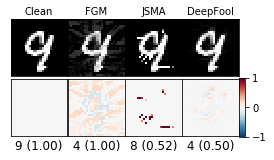

In [52]:
print('\nRandomly sample adversarial data from each category')

while True:
    ind = np.random.choice(X_test.shape[0])
    xorg, y0 = X_test[ind], y_test[ind]

    xorg = np.expand_dims(xorg, axis=0)
    z0 = np.argmax(y0)
    z1 = np.argmax(predict(xorg))

    if z0 != z1:
        continue

    xadvs = [make_fgsm(xorg, eps=0.02, epochs=10),
             make_jsma(xorg, eps=0.5, epochs=40),
             make_deepfool(xorg, epochs=1)]
    y2 = [predict(xi).flatten() for xi in xadvs]
    p2 = [np.max(yi) for yi in y2]
    z2 = [np.argmax(yi) for yi in y2]

    if np.all([z0 != z2]):
        break

fig = plt.figure(figsize=(4.2, 2.2))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.1], wspace=0.01,
                       hspace=0.01)
label = ['Clean', 'FGM', 'JSMA', 'DeepFool']

xorg = np.squeeze(xorg)
xadvs = [xorg] + xadvs
xadvs = [np.squeeze(e) for e in xadvs]

p2 = [np.max(y0)] + p2
z2 = [z0] + z2

for i in range(len(label)):
    x = xadvs[i]

    ax = fig.add_subplot(gs[0, i])
    ax.imshow(x, cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(label[i])
    ax.xaxis.set_label_position('top')

    ax = fig.add_subplot(gs[1, i])
    img = ax.imshow(x-xorg, cmap='RdBu_r', vmin=-1, vmax=1,
                    interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel('{0} ({1:.2f})'.format(z2[i], p2[i]), fontsize=12)

ax = fig.add_subplot(gs[1, 4])
dummy = plt.cm.ScalarMappable(cmap='RdBu_r',
                              norm=plt.Normalize(vmin=-1, vmax=1))
dummy.set_array([])
fig.colorbar(mappable=dummy, cax=ax, ticks=[-1, 0, 1], ticklocation='right')

You may study `DeepFool` and `CW` in more detail. See this reading list (ref: https://github.com/gongzhitaao/tensorflow-adversarial)
* Moment iterative attack https://arxiv.org/abs/1710.06081
* Virtual adversarial https://arxiv.org/abs/1507.00677
* CarliniWagner (CW) https://arxiv.org/abs/1608.04644
* Elastic net https://arxiv.org/abs/1709.04114
* MadryEtAl https://arxiv.org/abs/1706.06083
* Fast feature https://arxiv.org/abs/1511.05122
* Houdini https://arxiv.org/abs/1707.05373

A potential final project is to explain and compare these algorithms, e.g., on larger datasets like CIFAR10.

Another is to study/implement the winning attack and defense methods https://github.com/gongzhitaao/tensorflow-adversarial